# Load packages and audio files

In [2]:
import scipy, matplotlib.pyplot as plt, librosa, IPython.display, urllib
import torch
import torchaudio
import torchaudio.transforms as transforms
import torchaudio.functional as F
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import glob
import seaborn as sns

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram


from sklearn.datasets import load_digits
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
plt.rcParams['figure.figsize'] = (14, 4)

### Segment audio files

In [3]:
# Load audio files

# All files and directories ending with .wav
filenames = glob.glob("data/car_test/*.wav")
print(filenames)

['data/car_test\\Blinkers-hela.wav', 'data/car_test\\Chit-chat.wav', 'data/car_test\\Normal 40-50.wav', 'data/car_test\\Normal 40-70.wav', 'data/car_test\\Normal 60.wav', 'data/car_test\\Vindrutetorkare.wav']


In [4]:
label = ['B','T','N','N', 'N','V']
code = ['0','2','1','1', '1','0']

need duration in milliseconds

In [5]:
duration = [round(librosa.get_duration(filename=filename)*1000) for filename in filenames]
d_f_dict =list(zip(filenames, duration))
print(f'Filenames: duration in milliseconds: {d_f_dict}')

Filenames: duration in milliseconds: [('data/car_test\\Blinkers-hela.wav', 70476), ('data/car_test\\Chit-chat.wav', 239707), ('data/car_test\\Normal 40-50.wav', 70322), ('data/car_test\\Normal 40-70.wav', 164272), ('data/car_test\\Normal 60.wav', 83859), ('data/car_test\\Vindrutetorkare.wav', 80300)]


In [6]:
d_f_dict[0][1]

70476

In [7]:
from pydub import AudioSegment
filenames_2 = []
label_2 = []
code_2 = []

for i in range(len(filenames)):
    dur = d_f_dict[i][1]
    l = label[i]
    c = code[i]
    j = round(duration[i]/5000)
    for k in range(j):
        start = (k)*5000
        end = (k+1)*5000
        sound = AudioSegment.from_wav(filenames[i])
        extract = sound[start:end]
        extract.export(f"data/output_{l}_{c}_{k}.wav", format="wav")
        filenames_2.append(f"data/output_{l}_{c}_{k}.wav")
        label_2.append(l)
        code_2.append(c)

print(filenames_2)

C:\Users\AHUSSEI9\Anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


['data/output_B_0_0.wav', 'data/output_B_0_1.wav', 'data/output_B_0_2.wav', 'data/output_B_0_3.wav', 'data/output_B_0_4.wav', 'data/output_B_0_5.wav', 'data/output_B_0_6.wav', 'data/output_B_0_7.wav', 'data/output_B_0_8.wav', 'data/output_B_0_9.wav', 'data/output_B_0_10.wav', 'data/output_B_0_11.wav', 'data/output_B_0_12.wav', 'data/output_B_0_13.wav', 'data/output_T_2_0.wav', 'data/output_T_2_1.wav', 'data/output_T_2_2.wav', 'data/output_T_2_3.wav', 'data/output_T_2_4.wav', 'data/output_T_2_5.wav', 'data/output_T_2_6.wav', 'data/output_T_2_7.wav', 'data/output_T_2_8.wav', 'data/output_T_2_9.wav', 'data/output_T_2_10.wav', 'data/output_T_2_11.wav', 'data/output_T_2_12.wav', 'data/output_T_2_13.wav', 'data/output_T_2_14.wav', 'data/output_T_2_15.wav', 'data/output_T_2_16.wav', 'data/output_T_2_17.wav', 'data/output_T_2_18.wav', 'data/output_T_2_19.wav', 'data/output_T_2_20.wav', 'data/output_T_2_21.wav', 'data/output_T_2_22.wav', 'data/output_T_2_23.wav', 'data/output_T_2_24.wav', 'data

In [8]:
# check if all files are 10 sec
duration_2 = [round(librosa.get_duration(filename=filename)*1000) for filename in filenames_2]
duration_2[0:10]

[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]

In [19]:
# create dataframe full
frame = {'filename': filenames, 'label': label, 'code': code}
df = pd.DataFrame(frame)

# create dataframe segmented
frame = {'filename': filenames_2, 'label': label_2, 'code': code_2, 'duration': duration_2}
df_seg = pd.DataFrame(frame)
df_seg

,filename,label,code,duration
0,data/output_B_0_0.wav,B,0,5000
1,data/output_B_0_1.wav,B,0,5000
2,data/output_B_0_2.wav,B,0,5000
3,data/output_B_0_3.wav,B,0,5000
4,data/output_B_0_4.wav,B,0,5000
...,...,...,...,...
137,data/output_V_0_11.wav,V,0,5000
138,data/output_V_0_12.wav,V,0,5000
139,data/output_V_0_13.wav,V,0,5000
140,data/output_V_0_14.wav,V,0,5000


In [20]:
df_seg.drop([0,1,11,12,13, 62, 63, 64, 65, 124, 125, 126, 127, 128, 139, 141, 140], axis=0, inplace=True)

In [21]:
df_seg.reset_index(drop=True, inplace=True)

In [22]:
# Define function to load audio data
def load_audio(filename):
    waveform, sample_rate = torchaudio.load(filename, normalize=True)
    return waveform, sample_rate

In [46]:
load_audio(df_seg['filename'][50])

(tensor([[0.0592, 0.0596, 0.0599,  ..., 0.0335, 0.0330, 0.0331]]), 48000)

In [24]:
# illustrate
from IPython.display import Audio
import librosa
import seaborn as sb
sb.set(style="white", palette="muted")


## plotting functions
def plot_waveform(waveform, sr, title="Waveform"):
    figure, axes = plt.subplots(1, 1)
    axes.set_title(title)
    axes.grid(True)
    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axes.plot(time_axis, waveform[0], linewidth=1)
    plt.show(block=False)

def plot_filtered_waveform(signal, filtered_signal):
    plt.plot(signal, label="Original")
    plt.plot(filtered_signal, label="Filtered")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

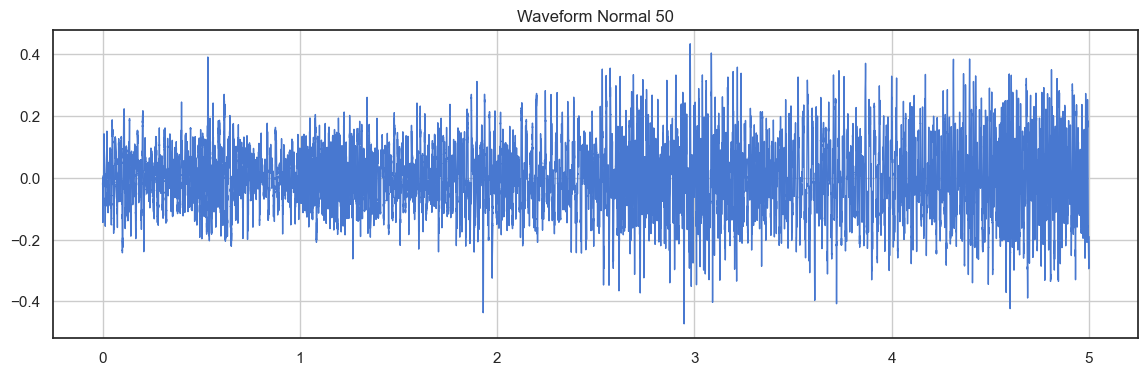

In [25]:
waveform, sample_rate = load_audio(df_seg[df_seg['label'] == 'N'].iloc[1]['filename'])
plot_waveform(waveform, sample_rate, title="Waveform Normal 50")
Audio(waveform.numpy(), rate=sample_rate)

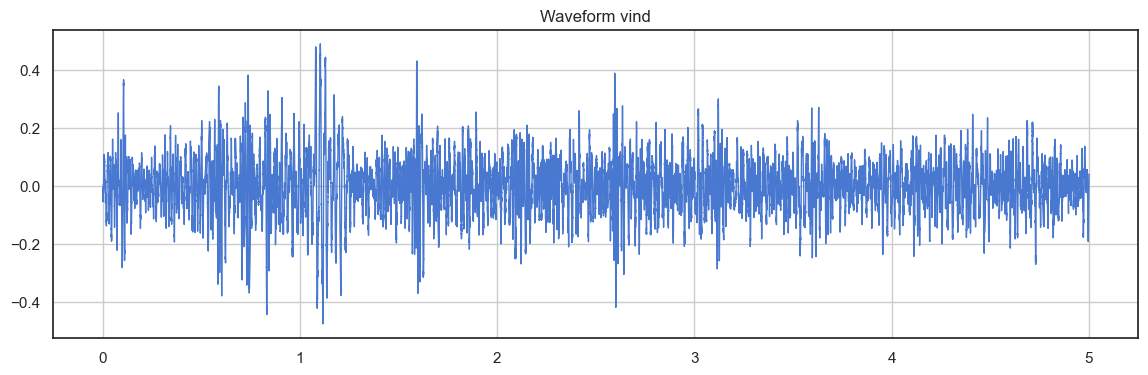

In [26]:
waveform, sample_rate = load_audio(df_seg[df_seg['label'] == 'V'].iloc[1]['filename'])
plot_waveform(waveform, sample_rate, title="Waveform vind")
Audio(waveform.numpy(), rate=sample_rate)

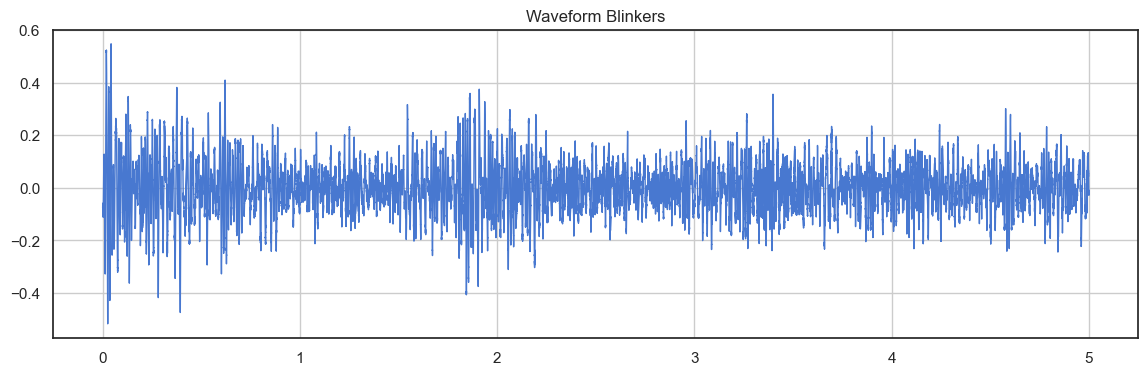

In [27]:
waveform, sample_rate = load_audio(df_seg[df_seg['label'] == 'B'].iloc[2]['filename'])
plot_waveform(waveform, sample_rate, title="Waveform Blinkers")
Audio(waveform.numpy(), rate=sample_rate)

In [52]:
def extract_cepstral_features(waveform, sample_rate):
    ''' MFCC - effective in capturing spectral features that are relevant to human perception
    Mean pitch - ? mean diffrence may be better '''
    sample_rate=sample_rate
    n_fft = 2048
    win_length = n_fft
    hop_length = int(win_length / 2)

    n_mfcc = 13
    mfcc_transform = torchaudio.transforms.MFCC(sample_rate=sample_rate,n_mfcc=n_mfcc,
                                                melkwargs={
                                                    "n_fft": n_fft,
                                                    "win_length": win_length,
                                                    "hop_length": hop_length,
                                                },)

    mfcc = mfcc_transform(waveform)
    mfcc = mfcc.mean(dim=2)

    pitch = F.detect_pitch_frequency(waveform, sample_rate).numpy()
    # Number of rows in mfcc
    n_rows = mfcc.shape[0]
    n_col = mfcc.shape[1]
    mfcc = mfcc.numpy()



    # # Subsample pitch to have the same number of rows as mfcc
    # pitch_subsampled = pitch[::pitch.shape[0]//n_rows]
    # # Concatenate arrays along the column axis (axis=1)
    # features = np.concatenate((pitch_subsampled, mfcc), axis=1)


    # Compute the mean of the pitch array
    mean_pitch = np.mean(pitch, axis =1)

    # Reshape the mean pitch to a 2D array with the same number of rows as mfcc
    mean_pitch = np.reshape(mean_pitch, (mfcc.shape[0],1))

    # Concatenate the mean pitch with the mfcc array along the column axis (axis=1)
    features = np.concatenate((mean_pitch, mfcc), axis=1)



    # gfcc_transform = torchaudio.transforms.GFCC(sample_rate=sample_rate)
    # gfcc = gfcc_transform(waveform)
    # gfcc = gfcc.mean(dim=2)

    return features.flatten()

In [54]:
extract_cepstral_features(load_audio(df_seg['filename'][0])[0],load_audio(df_seg['filename'][0])[1])

array([3000.      , -137.50272 ,  167.81705 ,   27.019634,   46.612366,
          5.666618,   31.13356 ,    4.893724,   21.5841  ,   -6.746491,
         16.427275,   -6.507695,    6.200741,   13.222201], dtype=float32)

In [55]:
cepstral_features = [extract_cepstral_features(load_audio(filename)[0],load_audio(filename)[1]) for filename in df_seg['filename']]

In [ ]:


X = StandardScaler().fit_transform(cepstral_features)
y=df_seg['code']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df_seg.code, random_state=0)

# pipeline class is used as estimator to enable
# search over different model types
pipe = Pipeline([
    ('model', SVC())
])

# single categorical value of 'model' parameter is
# sets the model class
# We will get ConvergenceWarnings because the problem is not well-conditioned.
# But that's fine, this is just an example.
linsvc_search = {
    'model': [LinearSVC(max_iter=1000)],
    'model__C': (1e-6, 1e+6, 'log-uniform'),
}

# explicit dimension classes can be specified like this
svc_search = {
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+10, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,13),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt = BayesSearchCV(
    pipe,
    # (parameter space, # of evaluations)
    [(svc_search, 40), (linsvc_search, 16)],
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

# Correlation of features

In [64]:
corr_matrix=pd.DataFrame(np.array(cepstral_features)).corr()

<AxesSubplot:>

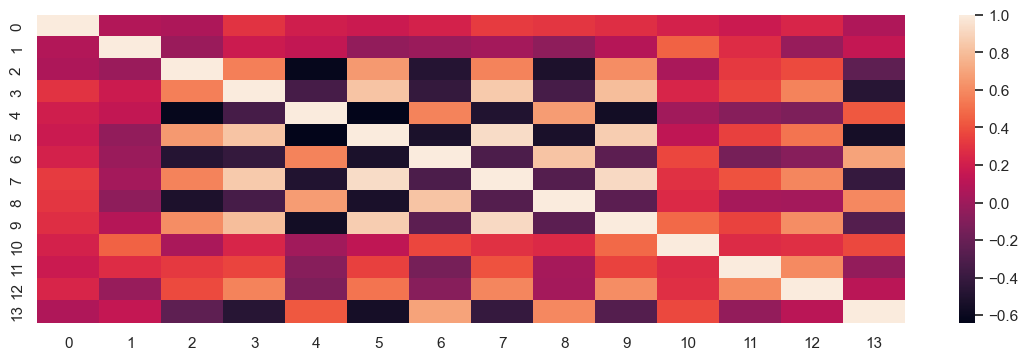

In [65]:
sns.heatmap(corr_matrix)

C:\Users\AHUSSEI9\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\AHUSSEI9\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\AHUSSEI9\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\AHUSSEI9\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\AHUSSEI9\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\AHUSSEI9\AppData\Roaming\P

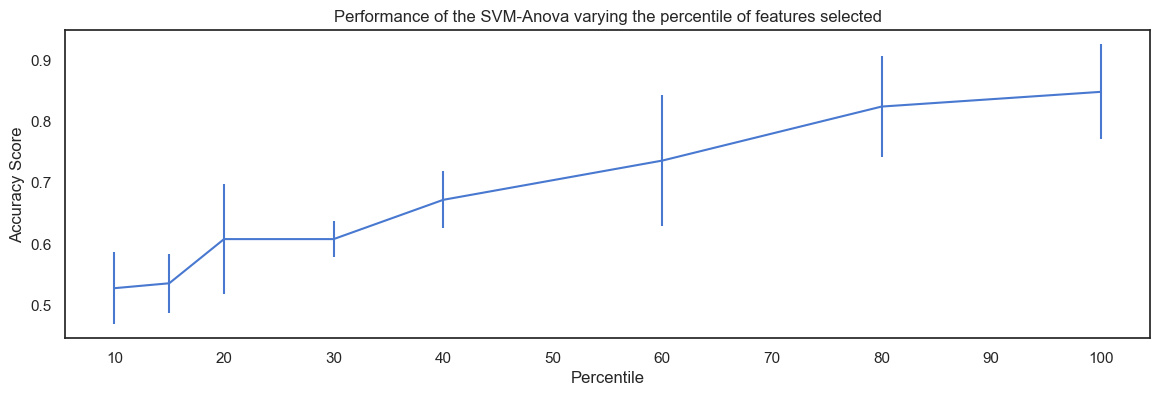

In [66]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import cross_val_score

# Create a feature-selection transform, a scaler and an instance of SVM that we
# combine together to have a full-blown estimator

clf = Pipeline(
    [
        ("anova", SelectPercentile(f_classif)),
        ("scaler", StandardScaler()),
        ("svc", LinearSVC(C=5.983584206064128)),
    ]
)
score_means = list()
score_stds = list()
percentiles = (10, 15, 20, 30, 40, 60, 80, 100)
X = cepstral_features
y = df_seg['code']
for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X, y)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title("Performance of the SVM-Anova varying the percentile of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Accuracy Score")
plt.axis("tight")
plt.show()